# Overview

From the analytic variance calculation, we can get that the Sobel formula is correct (although it has to distinguish between transitions a little bit more carefully than the Bellman equation).

Now we test our derived algorithm to see if it is capable of coming to the correct conclusions as well.

In [1]:
import numpy as np
from numpy.linalg import pinv
np.set_printoptions(precision=4, suppress=True)

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## Adjusted Analytic Expression

Note: it appears that there were issues w/ distinguishing the reward in the penultimate state-- it's either 0 or 1 with a certain probability, rather than 0.5 always.
After adding a terminal state with a reward of `1` to denote the bump event, the resulting approximation seems to agree with simulation.

In [2]:
# Chicken problem solved analytically
ns = 6
I = np.eye(ns)

# Probability of transitioning from state s_i --> s_j = P[i,j]
P = np.diag(np.ones(ns-1), 1) * 0.5
P[:,0] = 0.5
P[-1, 0] = 1

# Expected reward for transitioning from s_i --> s_j = R[i,j]
R = np.zeros((ns, ns))
R[-2, -1] = 1.0
r = np.sum(P*R, axis=1)

# Discount
gvec = np.ones(ns)*0.9
gvec[0] = 0
# gvec[-1] = 0
G = np.diag(gvec)

# Bootstrapping
L = np.eye(ns)*0.0

# Function approximation
X = np.eye(ns)


# Value function
v_pi = pinv(I - P @ G) @ r


# From sobel, recursive expected variance contribution?
T = -v_pi**2
for i in range(ns):
    for j in range(ns):
        T[i] += P[i,j] * (R[i,j] + gvec[j]*v_pi[j])**2

# Alternatively,
# T = np.sum(P * (R + G @ v_pi)**2, axis=1) - v_pi**2
        
# Variance (again from Sobel)
v_var = pinv(I - P @ G @ G) @ T 

print(v_pi)
print(T)
print(v_var)

[ 0.0205  0.0456  0.1013  0.225   0.5     0.    ]
[ 0.0004  0.0021  0.0103  0.0506  0.25   -0.    ]
[ 0.013   0.0311  0.0718  0.1519  0.25   -0.    ]


In [3]:
P

array([[ 0.5,  0.5,  0. ,  0. ,  0. ,  0. ],
       [ 0.5,  0. ,  0.5,  0. ,  0. ,  0. ],
       [ 0.5,  0. ,  0. ,  0.5,  0. ,  0. ],
       [ 0.5,  0. ,  0. ,  0. ,  0.5,  0. ],
       [ 0.5,  0. ,  0. ,  0. ,  0. ,  0.5],
       [ 1. ,  0. ,  0. ,  0. ,  0. ,  0. ]])

In [4]:
R

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

In [5]:
r

array([ 0. ,  0. ,  0. ,  0. ,  0.5,  0. ])

In [6]:
G

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0.9,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0.9,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0.9,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0.9,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0.9]])

In [239]:
# From later simulations...
var_exp

array([ 0.0126,  0.0301,  0.0696,  0.1509,  0.25  ])

# Simulation

In [7]:
class Chicken:
    ACTIONS = {'advance': 0, 'return': 1}
    initial_state = 0
    def __init__(self, ns):
        self.length = ns - 1
        self.reset()
        
    def do(self, action):
        if action == 0:
            if self._state == self.length:
                sp = self.initial_state
            else:
                sp = self._state + 1
        elif action == 1:
            sp = self.initial_state
        else:
            raise Exception("Invalid action:", action)
        r = self.reward(self._state, action, sp)
        self._state = sp
        return r, sp
    
    def reward(self, s, a, sp):
        if s == self.length and a == self.ACTIONS['advance']:
            return 1
        else:
            return 0
        
    def reset(self):
        self._state = self.initial_state

    def observe(self):
        return self._state

In [8]:
def generate_steps(env, pol, nsteps):
    ret = []
    env.reset()
    for i in range(nsteps):
        s = env.observe()
        a = policy(s)
        r, sp = env.do(a)
        
        ret.append((s, a, r, sp))
    return ret

In [9]:
def create_episodes(steps, *terminals):
    ret = []
    epi = []
    terminals = set(terminals)
    for step in steps:
        s, a, r, sp = step
        epi.append((s, a, r, sp))
        if sp in terminals:
            ret.append(epi)
            epi = []
    return ret

In [10]:
def compute_return(steps, gmfunc):
    ret = []
    g = 0
    for step in reversed(steps):
        s, a, r, sp = step
        g = r + gmfunc(sp)*g
        ret.append((s, a, g, sp))
    return list(reversed(ret))

def compute_lambda_return(steps, gmfunc, lmfunc, vfunc):
    pass

In [11]:
# Randomly choose either 0 or 1
def policy(s):
    return np.random.binomial(1, 0.5)

In [18]:
# Generate some steps
num_states = 5
slst = generate_steps(Chicken(num_states), policy, 100000)

In [19]:
gamma = lambda x: 0 if x == 0 else 0.9

In [20]:
glst = compute_return(slst, gamma)

In [21]:
gdf = pd.DataFrame(glst, columns=['s', 'a', 'g', 'sp'])

In [22]:
grouped = pd.groupby(gdf, 's')

In [23]:
grouped.aggregate({'g': np.mean})

g
s          
0  0.020452
1  0.045626
2  0.101407
3  0.226722
4  0.504693

In [24]:
grouped.aggregate({'g': np.var})

g
s          
0  0.013001
1  0.031181
2  0.071862
3  0.152671
4  0.250056

In [25]:
var_exp = grouped.aggregate({'g': np.var})['g'].as_matrix()

In [26]:
var_exp

array([ 0.013 ,  0.0312,  0.0719,  0.1527,  0.2501])

In [27]:
# Returns for each episode
#elst = [compute_return(ep, gamma) for ep in create_episodes(slst, 0)]

# Testing Algorithms on Simulated Data

In [28]:
class Int2Unary:
    """
    Convert integer to unary representation (e.g., for tabular case)
    """
    def __init__(self, length):
        self.length = length
        self._array = np.eye(length)

    def __call__(self, x):
        return self._array[x]

In [29]:
class TDVar_0:
    """Testing with known value function."""
    def __init__(self, n, w):
        """Initialize the learning algorithm.

        Parameters
        -----------
        n : int
            The number of features, i.e. expected length of the feature vector.
        """
        self.n = n
        self.reset()
        self.w = w

    def get_value(self, x):
        """Get the approximate value for feature vector `x`."""
        return np.dot(self.w, x)

    def get_variance(self, x):
        """Get the approximate variance for feature vector `x`."""
        return np.dot(self.u, x)
    
    def update(self, x, r, xp, alpha, beta, gm, gm_p, lm):
        """Update from new experience, i.e. from a transition `(x,r,xp)`."""
        delta = r + gm_p*np.dot(self.w, xp) - np.dot(self.w, x)

        vg = gm_p**2 # implicitly saying lambda is one?
        vr = delta**2
        vd = vr + vg*np.dot(self.u, xp) - np.dot(self.u, x)
        self.h = x
        self.u += beta*vd*self.h
        
    def reset(self):
        self.w = np.zeros(self.n)
        self.z = np.zeros(self.n)
        
        self.u = np.zeros(self.n)
        self.h = np.zeros(self.n)

In [30]:
# Setup
num_epochs = 20
# Tabular case
num_features = num_states

# Algorithm
alg = TDVar_0(num_features, v_pi[:-1])

# Representation
phi = Int2Unary(num_features)

# Parameters
gamma = lambda x: 0 if x == 0 else 0.9
lmbda = lambda x: 0 if x == 0 else 0

# Simulation
for epoch in range(num_epochs):
    alpha = 0.1/(5*(epoch+1)) + 0.0001
    beta  = alpha/2
    for step in slst:
        s, a, r, sp = step
        x = phi(s)
        xp = phi(sp)
        alg.update(x, r, xp, alpha, beta, gamma(s), gamma(sp), lmbda(s))
        
    print(epoch, alpha, beta)
    print(alg.w)
    print(alg.u)
    print()

0 0.0201 0.01005
[ 0.0205  0.0456  0.1013  0.225   0.5   ]
[ 0.0129  0.0298  0.0759  0.1548  0.25  ]

1 0.0101 0.00505
[ 0.0205  0.0456  0.1013  0.225   0.5   ]
[ 0.0132  0.0309  0.0751  0.1532  0.25  ]

2 0.006766666666666667 0.0033833333333333337
[ 0.0205  0.0456  0.1013  0.225   0.5   ]
[ 0.0133  0.0311  0.0747  0.1533  0.25  ]

3 0.0051 0.00255
[ 0.0205  0.0456  0.1013  0.225   0.5   ]
[ 0.0133  0.0311  0.0743  0.1535  0.25  ]

4 0.0041 0.00205
[ 0.0205  0.0456  0.1013  0.225   0.5   ]
[ 0.0133  0.031   0.0739  0.1536  0.25  ]

5 0.0034333333333333334 0.0017166666666666667
[ 0.0205  0.0456  0.1013  0.225   0.5   ]
[ 0.0133  0.031   0.0736  0.1536  0.25  ]

6 0.002957142857142857 0.0014785714285714285
[ 0.0205  0.0456  0.1013  0.225   0.5   ]
[ 0.0133  0.0309  0.0733  0.1536  0.25  ]

7 0.0026 0.0013
[ 0.0205  0.0456  0.1013  0.225   0.5   ]
[ 0.0133  0.0309  0.073   0.1535  0.25  ]

8 0.002322222222222222 0.001161111111111111
[ 0.0205  0.0456  0.1013  0.225   0.5   ]
[ 0.0133  0.03

In [31]:
class TDVar_1:
    """Learning both value function and variance at the same time (NO CORRECTION TRACE)"""
    def __init__(self, n):
        """Initialize the learning algorithm.

        Parameters
        -----------
        n : int
            The number of features, i.e. expected length of the feature vector.
        """
        self.n = n
        self.reset()

    def get_value(self, x):
        """Get the approximate value for feature vector `x`."""
        return np.dot(self.w, x)

    def get_variance(self, x):
        """Get the approximate variance for feature vector `x`."""
        return np.dot(self.u, x)
    
    def update(self, x, r, xp, alpha, beta, gm, gm_p, lm):
        """Update from new experience, i.e. from a transition `(x,r,xp)`."""
        delta = r + gm_p*np.dot(self.w, xp) - np.dot(self.w, x)
        self.z = x + gm*lm*self.z
        self.w += alpha*delta*self.z

        vg = gm_p**2 # implicitly saying lambda is one?
        vr = delta**2
        vd = vr + vg*np.dot(self.u, xp) - np.dot(self.u, x)
        self.h = x
        self.u += beta*vd*self.h
        
    def reset(self):
        self.w = np.zeros(self.n)
        self.z = np.zeros(self.n)
        
        self.u = np.zeros(self.n)
        self.h = np.zeros(self.n)

In [33]:
# Setup
num_epochs = 20
# Tabular case
num_features = num_states

# Algorithm
alg = TDVar_1(num_features)

# Representation
phi = Int2Unary(num_features)

# Parameters
gamma = lambda x: 0 if x == 0 else 0.9
lmbda = lambda x: 0 if x == 0 else 1

# Simulation
for epoch in range(num_epochs):
    alpha = 0.1/(5*(epoch+1)) + 0.0001
    beta  = alpha/2
    for step in slst:
        s, a, r, sp = step
        x = phi(s)
        xp = phi(sp)
        alg.update(x, r, xp, alpha, beta, gamma(s), gamma(sp), lmbda(s))
        
    print(epoch, alpha, beta)
    print(alg.w)
    print(alg.u)
    print()

0 0.0201 0.01005
[ 0.0323  0.0565  0.1114  0.213   0.4433]
[ 0.0117  0.0271  0.0696  0.1456  0.251 ]

1 0.0101 0.00505
[ 0.0255  0.0479  0.1039  0.2071  0.4479]
[ 0.0125  0.0291  0.0703  0.1455  0.25  ]

2 0.006766666666666667 0.0033833333333333337
[ 0.0227  0.0462  0.1006  0.205   0.4543]
[ 0.0129  0.03    0.0718  0.1484  0.2501]

3 0.0051 0.00255
[ 0.0217  0.0455  0.0982  0.2053  0.46  ]
[ 0.013   0.0303  0.0723  0.15    0.2501]

4 0.0041 0.00205
[ 0.0213  0.045   0.0967  0.2066  0.4645]
[ 0.0131  0.0304  0.0725  0.1507  0.2501]

5 0.0034333333333333334 0.0017166666666666667
[ 0.0211  0.0444  0.0957  0.2081  0.4679]
[ 0.0131  0.0304  0.0724  0.1511  0.2501]

6 0.002957142857142857 0.0014785714285714285
[ 0.021   0.044   0.0952  0.2095  0.4706]
[ 0.0131  0.0304  0.0723  0.1514  0.2501]

7 0.0026 0.0013
[ 0.0209  0.0436  0.0949  0.2108  0.4728]
[ 0.0131  0.0305  0.0722  0.1516  0.2501]

8 0.002322222222222222 0.001161111111111111
[ 0.0208  0.0433  0.0948  0.2118  0.4747]
[ 0.0131  0.03

Testing with lambda=1 for consistency's sake

In [34]:
# Setup
num_epochs = 20
# Tabular case
num_features = num_states

# Algorithm
alg = TDVar_1(num_features)

# Representation
phi = Int2Unary(num_features)

# Parameters
gamma = lambda x: 0 if x == 0 else 0.9
lmbda = lambda x: 1 if x == 1 else 1

# Simulation
u_lst = []
h_lst = []
for epoch in range(num_epochs):
#     alpha = 0.1/(5*(epoch+1)) + 0.0001
#     beta  = 0.0001
    alpha = 0.005
    beta = 0.0005
    for step in slst:
        s, a, r, sp = step
        x = phi(s)
        xp = phi(sp)
        alg.update(x, r, xp, alpha, beta, gamma(s), gamma(sp), lmbda(s))
        
        # Tracking
        u_lst.append(alg.u.copy())
        h_lst.append(alg.h.copy())
        
    print(epoch, alpha, beta)
    print(alg.w)
    print(alg.u)
    print()
    
h_lst = np.array(h_lst)
u_lst = np.array(u_lst)

u_td1 = np.copy(u_lst)

0 0.005 0.0005
[ 0.0216  0.0455  0.0981  0.2054  0.4605]
[ 0.0091  0.0216  0.0514  0.1139  0.2025]

1 0.005 0.0005
[ 0.0216  0.0455  0.0981  0.2054  0.4605]
[ 0.0123  0.0288  0.0673  0.1444  0.2407]

2 0.005 0.0005
[ 0.0216  0.0455  0.0981  0.2054  0.4605]
[ 0.013   0.0303  0.0707  0.1507  0.2484]

3 0.005 0.0005
[ 0.0216  0.0455  0.0981  0.2054  0.4605]
[ 0.0131  0.0306  0.0714  0.1519  0.25  ]

4 0.005 0.0005
[ 0.0216  0.0455  0.0981  0.2054  0.4605]
[ 0.0131  0.0307  0.0715  0.1522  0.2503]

5 0.005 0.0005
[ 0.0216  0.0455  0.0981  0.2054  0.4605]
[ 0.0131  0.0307  0.0715  0.1523  0.2503]

6 0.005 0.0005
[ 0.0216  0.0455  0.0981  0.2054  0.4605]
[ 0.0131  0.0307  0.0715  0.1523  0.2504]

7 0.005 0.0005
[ 0.0216  0.0455  0.0981  0.2054  0.4605]
[ 0.0131  0.0307  0.0715  0.1523  0.2504]

8 0.005 0.0005
[ 0.0216  0.0455  0.0981  0.2054  0.4605]
[ 0.0131  0.0307  0.0715  0.1523  0.2504]

9 0.005 0.0005
[ 0.0216  0.0455  0.0981  0.2054  0.4605]
[ 0.0131  0.0307  0.0715  0.1523  0.2504]



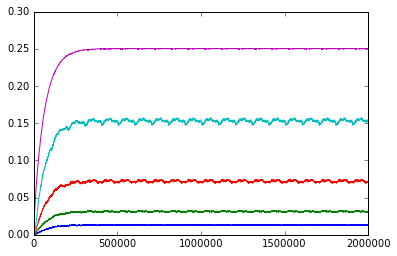

In [35]:
plt.plot(u_lst)

In [36]:
class TDVar_2:
    """Learning value function and variance (WITH CORRECTING TRACES)
    
    Not mathematically accurate because it effectively uses lambda=1 for variance iterates.
    That is, we estimate the variance of the MC-return from our existing value function,
    which may not be estimating the MC-return.
    """
    def __init__(self, n):
        """Initialize the learning algorithm.

        Parameters
        -----------
        n : int
            The number of features, i.e. expected length of the feature vector.
        """
        self.n = n
        self.reset()

    def get_value(self, x):
        """Get the approximate value for feature vector `x`."""
        return np.dot(self.w, x)

    def get_variance(self, x):
        """Get the approximate variance for feature vector `x`."""
        return np.dot(self.u, x)
    
    def update(self, x, r, xp, alpha, beta, gm, gm_p, lm):
        """Update from new experience, i.e. from a transition `(x,r,xp)`."""
        delta = r + gm_p*np.dot(self.w, xp) - np.dot(self.w, x)
        self.z = x + gm*lm*self.z
        self.w += alpha*delta*self.z

        vg = gm_p**2 # implicitly saying lambda is one?
        vr = delta**2
        vd = vr + vg*np.dot(self.u, xp) - np.dot(self.u, x)
        self.e = x # no eligibility trace for variance 
        self.u += beta*(vd*self.e + delta*self.h)
        self.h = gm_p*(x*delta) + gm*self.h
        
    def reset(self):
        self.w = np.zeros(self.n)
        self.z = np.zeros(self.n)
        
        self.u = np.zeros(self.n)
        self.e = np.zeros(self.n)
        self.h = np.zeros(self.n)

In [37]:
# Setup
num_epochs = 20
# Tabular case
num_features = num_states

# Algorithm
alg = TDVar_2(num_features)

# Representation
phi = Int2Unary(num_features)

# Parameters
gamma = lambda x: 0 if x == 0 else 0.9
lmbda = lambda x: 1 if x == 0 else 1

# Simulation
u_lst = []
h_lst = []
for epoch in range(num_epochs):
#     alpha = 0.1/(5*(epoch+1)) + 0.0001
#     beta  = 0.0001
    alpha = 0.005
    beta = 0.0005
    for step in slst:
        s, a, r, sp = step
        x = phi(s)
        xp = phi(sp)
        alg.update(x, r, xp, alpha, beta, gamma(s), gamma(sp), lmbda(s))
        
        # Tracking
        u_lst.append(alg.u.copy())
        h_lst.append(alg.h.copy())
        
    print(epoch, alpha, beta)
    print(alg.w)
    print(alg.u)
    print()
    
h_lst = np.array(h_lst)
u_lst = np.array(u_lst)

u_td2 = np.copy(u_lst)

0 0.005 0.0005
[ 0.0216  0.0455  0.0981  0.2054  0.4605]
[ 0.0091  0.0215  0.0512  0.1133  0.2025]

1 0.005 0.0005
[ 0.0216  0.0455  0.0981  0.2054  0.4605]
[ 0.0122  0.0286  0.067   0.1435  0.2407]

2 0.005 0.0005
[ 0.0216  0.0455  0.0981  0.2054  0.4605]
[ 0.0129  0.0302  0.0703  0.1498  0.2484]

3 0.005 0.0005
[ 0.0216  0.0455  0.0981  0.2054  0.4605]
[ 0.013   0.0305  0.071   0.1511  0.25  ]

4 0.005 0.0005
[ 0.0216  0.0455  0.0981  0.2054  0.4605]
[ 0.0131  0.0305  0.0711  0.1514  0.2503]

5 0.005 0.0005
[ 0.0216  0.0455  0.0981  0.2054  0.4605]
[ 0.0131  0.0305  0.0711  0.1514  0.2503]

6 0.005 0.0005
[ 0.0216  0.0455  0.0981  0.2054  0.4605]
[ 0.0131  0.0306  0.0711  0.1514  0.2504]

7 0.005 0.0005
[ 0.0216  0.0455  0.0981  0.2054  0.4605]
[ 0.0131  0.0306  0.0711  0.1514  0.2504]

8 0.005 0.0005
[ 0.0216  0.0455  0.0981  0.2054  0.4605]
[ 0.0131  0.0306  0.0711  0.1514  0.2504]

9 0.005 0.0005
[ 0.0216  0.0455  0.0981  0.2054  0.4605]
[ 0.0131  0.0306  0.0711  0.1514  0.2504]



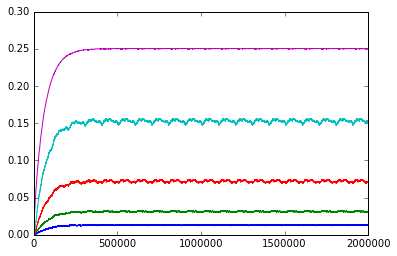

In [38]:
plt.plot(u_lst)

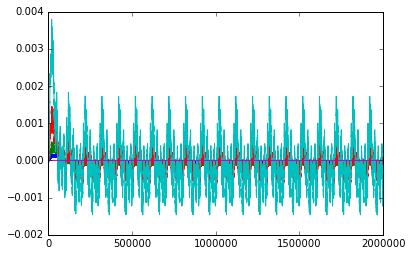

In [40]:
plt.plot(u_td2 - u_td1)

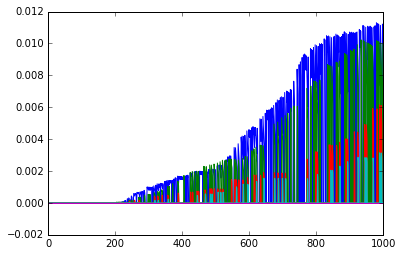

In [41]:
plt.plot(h_lst[:1000])

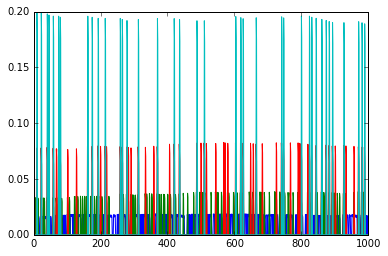

In [42]:
plt.plot(h_lst[-1000:])

In [ ]:
# class TDVar_3:
#     def __init__(self, n):
#         """Initialize the learning algorithm.

#         Parameters
#         -----------
#         n : int
#             The number of features, i.e. expected length of the feature vector.
#         """
#         self.n = n
#         self.reset()

#     def get_value(self, x):
#         """Get the approximate value for feature vector `x`."""
#         return np.dot(self.w, x)

#     def get_variance(self, x):
#         """Get the approximate variance for feature vector `x`."""
#         return np.dot(self.u, x)
    
#     def update(self, x, r, xp, alpha, beta, gm, gm_p, lm):
#         """Update from new experience, i.e. from a transition `(x,r,xp)`."""
#         delta = r + gm_p*np.dot(self.w, xp) - np.dot(self.w, x)
#         self.z = x + gm*lm*self.z
#         self.w += alpha*delta*self.z

#         vg = gm_p**2 # implicitly saying lambda is one?
#         vr = delta**2
#         vd = vr + vg*np.dot(self.u, xp) - np.dot(self.u, x)
#         self.e = x # no eligibility trace for variance 
#         self.u += beta*(vd*self.e + delta*self.h)
#         self.h = gm_p*(x*delta) + gm*self.h
        
#     def reset(self):
#         self.w = np.zeros(self.n)
#         self.z = np.zeros(self.n)
        
#         self.u = np.zeros(self.n)
#         self.e = np.zeros(self.n)
#         self.h = np.zeros(self.n)